In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def generate_noise(mean, std, nsamples):

    return np.random.normal(mean, std, nsamples)


def generate_peak(start, amplitude, rise, fallout, nsamples):

    waveform = np.zeros(nsamples)

    max_index = start + rise
    rise_indices = np.arange(start, max_index+1, 1)
    slope = amplitude / rise
    waveform[start:max_index+1] = slope * (rise_indices - start)

    fall_start = max_index+1
    fall_indices = np.arange(fall_start, nsamples)
    waveform[fall_start:] = amplitude * np.exp(-(fall_indices + 1 - fall_start) / fallout)

    return waveform


def generate_waveform(start_list, amplitude_list, rise, fallout, noise_mean, noise_std, nsamples):

    waveform = generate_noise(noise_mean, noise_std, nsamples)

    for start, amplitude in zip(start_list, amplitude_list):

        waveform += generate_peak(start, amplitude, rise, fallout, nsamples)

    return waveform

In [3]:
def find_include_peaks(df_wave, peak_height, peak_prominence, peak_wlen):

    peaks = find_peaks(df_wave['Waveform'], height=peak_height, prominence=peak_prominence, wlen=peak_wlen)
    peak_indices = peaks[0]

    df_peaks = pd.DataFrame({'Bin': peak_indices, 'IsPeak': True, 'PeakNumber': np.arange(1, len(peak_indices)+1)})

    df_wave = pd.merge(df_wave, df_peaks, on='Bin', how='left')
    df_wave['IsPeak'].fillna(False, inplace=True)

    return df_wave
    

def mask_baseline_compatible(waveform, baseline_range, random_thresholds=0.1):

    init_baseline = waveform[baseline_range[0]:baseline_range[1]]
    init_baseline_mean = init_baseline.mean()
    init_baseline_std = init_baseline.std()

    nsamples = len(waveform)
    quantile = 1 - random_thresholds / nsamples
    Z_deviation = norm.ppf(quantile)

    upper_bound = init_baseline_mean + init_baseline_std * Z_deviation

    baseline_mask = waveform <= upper_bound

    return baseline_mask


def include_baseline(df_wave, baseline_range):

    df_baseline = df_wave.copy()

    baseline_mask = mask_baseline_compatible(df_baseline['Waveform'], baseline_range)
    df_baseline['Baseline'] = False
    df_baseline.loc[baseline_mask, 'Baseline'] = True

    return df_baseline


def get_nearest_peak(bin, peak_bins, peak_numbers):

    index = np.argmin(np.abs(bin-peak_bins))
    return peak_numbers[index]


def include_nearest_peaks(df_wave):

    mask_peaks = df_wave['IsPeak']
    peak_bins = np.array(df_wave.loc[mask_peaks, 'Bin'])
    peak_numbers = np.array(df_wave.loc[mask_peaks, 'PeakNumber'])

    if len(peak_bins) == 0:
        raise ValueError('There are no peaks!')

    nearest_peaks = df_wave['Bin'].apply(get_nearest_peak, args=(peak_bins, peak_numbers))

    df_peaks = df_wave.copy()
    df_peaks['PeakNumber'] = nearest_peaks
    df_peaks.loc[df_peaks['Baseline'], 'PeakNumber'] = None
    
    return df_peaks


def clear_baseline_near_peaks(df_wave):

    df_clear = df_wave.copy()

    for peak_number, df_peak_number in df_wave.groupby('PeakNumber'):

        min_bin = df_peak_number['Bin'].min()
        max_bin = df_peak_number['Bin'].max()

        mask_bin = (df_clear['Bin'] >= min_bin) & (df_clear['Bin'] <= max_bin)
        df_clear.loc[mask_bin, 'PeakNumber'] = peak_number
        df_clear.loc[mask_bin, 'Baseline'] = False

    return df_clear


def include_contiguous_peaks(df_wave):

    peak_numbers = df_wave['PeakNumber'].dropna().unique()
    contiguous = np.zeros(len(peak_numbers), dtype=bool)

    for peak_index, (peak_left, peak_right) in enumerate(zip(peak_numbers[0:-1], peak_numbers[1:])):

        df_left = df_wave.loc[df_wave['PeakNumber'] == peak_left]
        df_right = df_wave.loc[df_wave['PeakNumber'] == peak_right]

        min_bin_diff = df_right['Bin'].values[0] - df_left['Bin'].values[-1]

        if min_bin_diff == 1:
            contiguous[peak_index] = True
            contiguous[peak_index+1] = True

    df_contiguous = pd.DataFrame({'PeakNumber': peak_numbers, 'IsContiguous': contiguous})

    df_merge = pd.merge(df_wave, df_contiguous, on='PeakNumber', how='left')

    return df_merge


def include_offset_waveform(df_wave):

    df_offset = df_wave.copy()

    baseline_mean = df_wave.loc[df_wave['Baseline'], 'Waveform'].mean()

    df_offset['WaveformOffset'] = df_offset['Waveform'] - baseline_mean

    return df_offset


def expand_signal(df_wave, window):

    df_expanded = df_wave.copy()

    df_last_bins = df_wave.groupby('PeakNumber').agg({'Bin': 'max'}).reset_index()
    last_bins = df_last_bins['Bin'].values
    peak_numbers = df_last_bins['PeakNumber'].values

    for last_bin, peak_number in zip(last_bins, peak_numbers):

        if last_bin + window < df_expanded.shape[0]:
            right_edge = last_bin + window
        else:
            right_edge = None

        mask_bin = (df_expanded['Bin'] >= last_bin) & (df_expanded['Bin'] < right_edge)
        df_expanded.loc[mask_bin, 'Baseline'] = False

        mask_peakna = df_expanded['PeakNumber'].isna()
        df_expanded.loc[mask_bin & mask_peakna, 'PeakNumber'] = peak_number

    return df_expanded


def create_dataframe(waveform, baseline_range=(0, 100),
                     peak_height=10, peak_prominence=5, peak_wlen=10,
                     expansion_window=25):

    df_wave = pd.DataFrame()
    df_wave['Waveform'] = waveform
    df_wave['Bin'] = np.arange(0, len(waveform), 1)

    df_wave = find_include_peaks(df_wave, peak_height, peak_prominence, peak_wlen)

    df_wave = include_baseline(df_wave, baseline_range)

    df_wave = include_nearest_peaks(df_wave)

    df_wave = clear_baseline_near_peaks(df_wave)

    df_wave = include_contiguous_peaks(df_wave)

    df_wave = expand_signal(df_wave, expansion_window)

    df_wave = include_offset_waveform(df_wave)

    return df_wave

In [4]:
noise_mean = 12
noise_std = 0.5

peak = generate_waveform([100, 130, 500], [50, 50, 50], 15, 30, 
                         noise_mean=noise_mean, noise_std=noise_std, 
                         nsamples=1000)

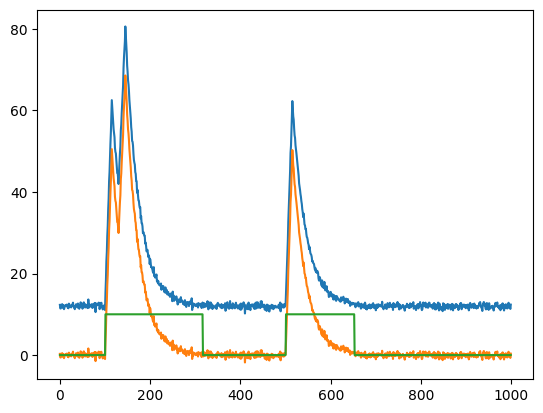

In [5]:
df_waveform = create_dataframe(peak)

plt.plot(df_waveform['Waveform'])
plt.plot(df_waveform['WaveformOffset'])
plt.plot(~df_waveform['Baseline'] * 10)
plt.show()